In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["DGLBACKEND"] = "pytorch"
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling, MaxPooling
from tqdm.notebook import tqdm
from dgl.data.utils import save_graphs, load_graphs

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data = h5py.File(
    "/home2/hky/github/Gamma_Energy/AllSky_originData/Data/gamma_allsky_compress_cuted.h5",
    "r",
)
loc = np.loadtxt(
    "/home2/hky/github/Gamma_Energy/AllSky_originData/TibetIII-forplot.loc"
)

In [4]:
for k in data:
    print(k)

MD
Tibet
age
cx
cy
inout
mr1
nch
ne
phi
pricx
pricy
prie
prie_num
priid
prik
prine
priphi
pritheta
sigma
summd
sumpd
sumpf
theta


In [5]:
train_val_index, test_index = train_test_split(
    range(len(data["prie"])), random_state=42, test_size=0.8
)
train_index, val_index = train_test_split(
    train_val_index, random_state=42, test_size=0.3
)

In [6]:
def create_graph(savepath, save_index, k):
    Tibet = data["Tibet"][:, :, :][save_index]
    prie = torch.tensor(
        np.log10(data["prie"][:][save_index] / 1000), dtype=torch.float32
    )
    theta = torch.tensor(data["pritheta"][:][save_index], dtype=torch.float32)
    phi = torch.tensor(data["priphi"][:][save_index], dtype=torch.float32)
    graphs = list()
    for index in tqdm(range(len(prie))):
        particle_num = Tibet[index, :, 0]
        time = Tibet[index, :, 1]
        need = np.where((particle_num >= 0.4) & (np.abs(time) < 800))
        nnode = len(need[0])
        xdata = np.zeros([nnode, 4], dtype=np.float32)
        xdata[:, 0] = np.log10(particle_num[need])
        xdata[:, 1] = time[need] / 500
        xdata[:, 2] = loc[need][:, 3] / 75
        xdata[:, 3] = loc[need][:, 4] / 75

        #         src = np.array([n for n in range(nnode) for _ in range(nnode)], dtype=np.int32)
        #         dst = np.array(list(range(nnode)) * nnode, dtype=np.int32)
        #         need_del = np.where(src == dst)
        #         src = np.delete(src, need_del[0])
        #         dst = np.delete(dst, need_del[0])
        #         src = torch.tensor(src)
        #         dst = torch.tensor(dst)
        xdata = torch.from_numpy(xdata)
        g = dgl.knn_graph(xdata[:, 2:], k=k)
        g.ndata["xdata"] = xdata
        graphs.append(g)
    save_graphs(savepath, graphs, {"prie": prie, "pritheta": theta, "priphi": phi})

In [7]:
for k in range(11, 17):
    savepath = f"/cxtmp/hky/ICRCdata/gamma_train_dgl_knn_{k}.bin"
    create_graph(savepath, train_index, k)
    savepath = f"/cxtmp/hky/ICRCdata/gamma_val_dgl_knn_{k}.bin"
    create_graph(savepath, val_index, k)

  0%|          | 0/266956 [00:00<?, ?it/s]

  0%|          | 0/114411 [00:00<?, ?it/s]

  0%|          | 0/266956 [00:00<?, ?it/s]

  0%|          | 0/114411 [00:00<?, ?it/s]

  0%|          | 0/266956 [00:00<?, ?it/s]

  0%|          | 0/114411 [00:00<?, ?it/s]

  0%|          | 0/266956 [00:00<?, ?it/s]

  0%|          | 0/114411 [00:00<?, ?it/s]

  0%|          | 0/266956 [00:00<?, ?it/s]

/home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 14, got k = 15, use k = 14
  dgl_warning(


  0%|          | 0/114411 [00:00<?, ?it/s]

  0%|          | 0/266956 [00:00<?, ?it/s]

/home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 15, got k = 16, use k = 15
  dgl_warning(
/home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/transforms/functional.py:308: DGLWarning: 'k' should be less than or equal to the number of points in 'x'expect k <= 14, got k = 16, use k = 14
  dgl_warning(


  0%|          | 0/114411 [00:00<?, ?it/s]

In [6]:
# savepath = f"/cxtmp/hky/ICRCdata/gamma_test_dgl_knn_10.bin"
# create_graph(savepath, test_index, 10)

In [8]:
class Gamma_Allsky_dgl(DGLDataset):
    def __init__(self, path):
        self.graph, self.labels = load_graphs(path)

    def __len__(self):
        return len(self.graph)

    def __getitem__(self, index):
        return (self.graph[index], self.labels["prie"][index])

In [9]:
class MLP(nn.Module):
    """Construct two-layer MLP-type aggreator for GIN model"""

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)


class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        num_layers = 5
        # five-layer GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(hidden_dim, hidden_dim, hidden_dim)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
            )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(input_dim, hidden_dim))
            else:
                self.linear_prediction.append(nn.Linear(hidden_dim, hidden_dim))
        self.drop = nn.Dropout(0)
        self.pool = (
            MaxPooling()
        )  # change to mean readout (AvgPooling) on social network datasets
        self.classify = nn.Linear(hidden_dim * num_layers, output_dim * 10)
        self.classify2 = nn.Linear(output_dim * 10, output_dim)

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = list()
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer.append(self.drop(self.linear_prediction[i](pooled_h)))
        #             print(score_over_layer[i].shape)
        score_over_layer = torch.cat(score_over_layer, dim=1)
        score_over_layer = self.classify(score_over_layer)
        score_over_layer = self.classify2(score_over_layer).view(-1, 1)
        return score_over_layer

In [10]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # 应用图卷积和激活函数
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        h = F.relu(self.conv3(g, h))
        with g.local_scope():
            g.ndata["h"] = h
            # 使用平均读出计算图表示
            hg = dgl.readout_nodes(g, "h", op="sum")
            return self.classify(hg).view(-1, 1)

In [11]:
from dgl.nn import SAGEConv


class SAGE(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()
        self.layers = nn.ModuleList()
        # two-layer GraphSAGE-mean
        self.layers.append(SAGEConv(in_size, hid_size, "gcn"))
        self.layers.append(SAGEConv(hid_size, hid_size, "gcn"))
        self.classify = nn.Linear(hid_size, out_size)
        self.dropout = nn.Dropout(0)

    def forward(self, graph, x):
        h = self.dropout(x)
        for l, layer in enumerate(self.layers):
            h = layer(graph, h)
            if l != len(self.layers) - 1:
                h = F.relu(h)
                h = self.dropout(h)
        with graph.local_scope():
            graph.ndata["h"] = h
            hg = dgl.readout_nodes(graph, "h", op="sum")
            return self.classify(hg).view(-1, 1)

In [12]:
model_name = ["GIN"]
result = dict()

for k in range(11, 17):
    train_path = f"/cxtmp/hky/ICRCdata/gamma_train_dgl_knn_{k}.bin"
    val_path = f"/cxtmp/hky/ICRCdata/gamma_val_dgl_knn_{k}.bin"

    MCdataset_train = Gamma_Allsky_dgl(train_path)
    MCdataset_val = Gamma_Allsky_dgl(val_path)

    train_dataloader = GraphDataLoader(
        MCdataset_train, batch_size=256, drop_last=False, num_workers=4, shuffle=True
    )
    val_dataloader = GraphDataLoader(
        MCdataset_val, batch_size=256, drop_last=False, num_workers=4, shuffle=False
    )

    test = next(iter(train_dataloader))
    test[0].to(device)

    for i, modeltype in enumerate([GIN]):
        val_loss_best = 1
        model = modeltype(4, 16, 1).to(device)
        maxtpoch = 80
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
#         lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, maxtpoch)
        lossfunction = nn.MSELoss()

        for epoch in range(maxtpoch):
            model.train()
            for batched_graph, labels in train_dataloader:
                if batched_graph.num_edges() > 2e8:
                    continue
                batched_graph, labels = batched_graph.to(device), labels.to(
                    device
                ).reshape(-1, 1)
                pred = model(batched_graph, batched_graph.ndata["xdata"])
#                 print(pred)
                loss = lossfunction(pred, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            #         print(loss)
#             lr_scheduler.step()
            y_pred = list()
            y_orgin = list()
            model.eval()
            with torch.no_grad():
                for batched_graph, labels in val_dataloader:
                    if batched_graph.num_edges() > 2e8:
                        continue
                    batched_graph, labels = batched_graph.to(device), labels.to(device)
                    pred = model(batched_graph, batched_graph.ndata["xdata"])
                    y_pred.append(pred.cpu().numpy())
                    y_orgin.append(labels.cpu().numpy())
            y_pred = np.concatenate(y_pred).reshape(-1)
            y_orgin = np.concatenate(y_orgin)
            val_loss = np.mean((y_pred - y_orgin) ** 2)
#             print(val_loss)
            if val_loss < val_loss_best:
                val_loss_best = val_loss
                torch.save(
                    model.state_dict(), f"/cxtmp/hky/ICRCdata/{model_name[i]}_{k}_Adam_new.pt"
                )
                result[f"{model_name[i]}_{k}"] = val_loss_best
                print(f"{epoch} {model_name[i]}_{k}", val_loss_best)

/home2/hky/miniconda3/envs/dgl/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


0 GIN_11 0.034088638
1 GIN_11 0.029840373
2 GIN_11 0.02817922
3 GIN_11 0.027546188
4 GIN_11 0.02730397
5 GIN_11 0.025990024
7 GIN_11 0.025743168
10 GIN_11 0.02510719
11 GIN_11 0.024900656
12 GIN_11 0.024750195
13 GIN_11 0.024657087
15 GIN_11 0.024452083
17 GIN_11 0.0241647
27 GIN_11 0.023601577
34 GIN_11 0.02346462
38 GIN_11 0.023368524
46 GIN_11 0.02331407
54 GIN_11 0.023309205
71 GIN_11 0.023102308
75 GIN_11 0.02304005
78 GIN_11 0.02300541
0 GIN_12 0.032558966
1 GIN_12 0.02840889
2 GIN_12 0.026654322
4 GIN_12 0.026528284
6 GIN_12 0.025445327
10 GIN_12 0.02542636
11 GIN_12 0.0248498
14 GIN_12 0.02442086
15 GIN_12 0.024404246
17 GIN_12 0.024100075
19 GIN_12 0.02408237
24 GIN_12 0.023991661
25 GIN_12 0.023842188
27 GIN_12 0.023774033
28 GIN_12 0.023606319
29 GIN_12 0.023596548
33 GIN_12 0.023543721
40 GIN_12 0.023347888
43 GIN_12 0.02308775
50 GIN_12 0.02305208
71 GIN_12 0.022945032
79 GIN_12 0.022858646
0 GIN_13 0.032951508
1 GIN_13 0.029441202
2 GIN_13 0.029283186
3 GIN_13 0.027446687

KeyboardInterrupt: 

In [ ]:
print(result)

In [ ]:
# val_loss_list =list()
# for i in result.keys():
#     val_loss_list.append(result[i])

In [22]:
model = GIN(4, 16, 1).to(device)
model.load_state_dict(torch.load( f"/cxtmp/hky/ICRCdata/GIN_{10}_Adam_new.pt"))

<All keys matched successfully>

In [23]:
test_path = f"/cxtmp/hky/ICRCdata/gamma_test_dgl_knn_{10}.bin"

MCdataset_test = Gamma_Allsky_dgl(test_path)

test_dataloader = GraphDataLoader(
    MCdataset_test, batch_size=256, drop_last=False, num_workers=4, shuffle=False
)
model.eval()
y_pred = list()
y_orgin = list()
with torch.no_grad():
    for batched_graph, labels in test_dataloader:
        if batched_graph.num_edges() > 2e8:
            continue
        batched_graph, labels = batched_graph.to(device), labels.to(device)
        pred = model(batched_graph, batched_graph.ndata["xdata"])
        y_pred.append(pred.cpu().numpy())
        y_orgin.append(labels.cpu().numpy())
y_pred = np.concatenate(y_pred).reshape(-1)
y_orgin = np.concatenate(y_orgin)
val_loss = np.mean((y_pred - y_orgin) ** 2)

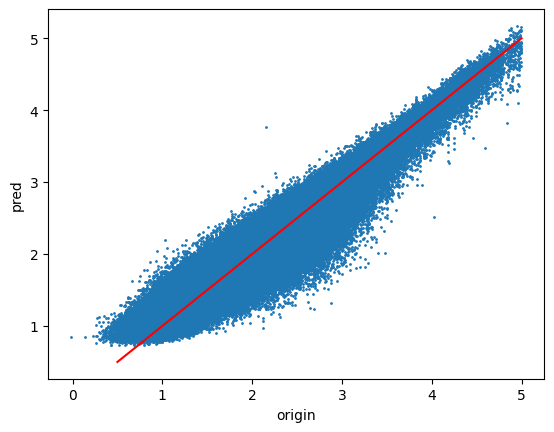

In [24]:
x=np.linspace(0.5,5)
plt.scatter(y_orgin,y_pred,s=1)
plt.plot(x,x,c="r")
plt.ylabel("pred")
plt.xlabel("origin")
plt.show()

In [25]:
newdata = dict()
for para in data:
    if para not in ["Tibet","MD"]:
        newdata[para] = data[para][:][test_index]
newdata["GIN_Energy"] = y_pred

In [28]:
newdata

{'age': array([0.78757978, 0.83530966, 1.27184005, ..., 0.89952723, 0.7238766 ,
        0.49854519]),
 'cx': array([  40.96136429,  -41.24355796,   75.02616021, ...,   56.33998744,
         -49.17675182, -102.2785714 ]),
 'cy': array([-36.42954179, -12.18750573,  38.72055522, ...,  60.5955183 ,
         51.85961624, -23.84869615]),
 'inout': array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'mr1': array([53.49270138, 39.2244279 , 55.67924866, ..., 32.19611886,
        22.8512814 , 37.28707292]),
 'nch': array([245,  79,  21, ...,  18,  27,  17], dtype=int32),
 'ne': array([377564.75061167,  42075.86744255,  18202.78948356, ...,
         10265.07668486,  13640.2677972 ,  47703.04731955]),
 'phi': array([-16.17095853,  79.31958072,  16.67024746, ...,  74.77165179,
        -32.64360104, -32.34111811]),
 'pricx': array([  41.806,  -42.46 ,  103.752, ...,   41.81 ,  -49.914, -111.22 ]),
 'pricy': array([-37.194, -11.746,  54.75 , ...,  70.018,  52.007, -21.886]),
 'prie': array([319951.4375    

In [27]:
np.savez(f"/cxtmp/hky/ICRCdata/gamma_test_with_dgl.npz",**newdata)

In [29]:
plt.scatter(y_orgin,newdata["S50"],s=1)
plt.ylabel("pred")
plt.xlabel("origin")
plt.show()

KeyError: 'S50'